In [156]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from scipy import stats
import sympy as sym

from sklearn.preprocessing import normalize
from itertools import combinations

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
import skccm as ccm

import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from itertools import product
import warnings
import itertools

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [14,5]

## Оглавление:
* [EDA и подготовка данных к дальнейшему анализу](#first-bullet)
* [Проверка наличия лаговых связей тестом Гренджера](#second-bullet)
* [Альтернативные методы определения лаговых связей](#third-bullet)
* [Выводы](#fourth-bullet)

# EDA и подготовка данных к дальнейшему анализу <a class="anchor" id="first-bullet"></a>

Загрузим данные и приведем к более удобному виду: тикеры активов сделаем столбцами, таймстампы - индексом.

In [37]:
quotes_df = pd.read_csv("QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv", parse_dates=['Timestamp'])
quotes_df = quotes_df.pivot_table(index = 'Timestamp', values = 'Close Candle', columns = 'Ticker Full Name')
quotes_df.sort_index(ascending=True, inplace=True)
display(quotes_df)

Ticker Full Name,10 YEAR TREASURY NOTE FUTURES,E-MINI S&P 500 FUTURES,FTSE CHINA A50 INDEX FUTURES
Timestamp,,,
2020-01-01 18:01:00,128.312,3236.25,NaN
2020-01-01 18:02:00,128.312,3234.75,NaN
2020-01-01 18:03:00,128.312,3235.25,NaN
2020-01-01 18:04:00,128.312,3236.00,NaN
2020-01-01 18:05:00,128.328,3235.50,NaN
...,...,...,...
2021-11-30 23:55:00,NaN,4605.75,15390.0
2021-11-30 23:56:00,NaN,4606.75,15390.0
2021-11-30 23:57:00,NaN,4606.50,15388.0


Построим ради интереса матрицу корреляций между ценами активов.

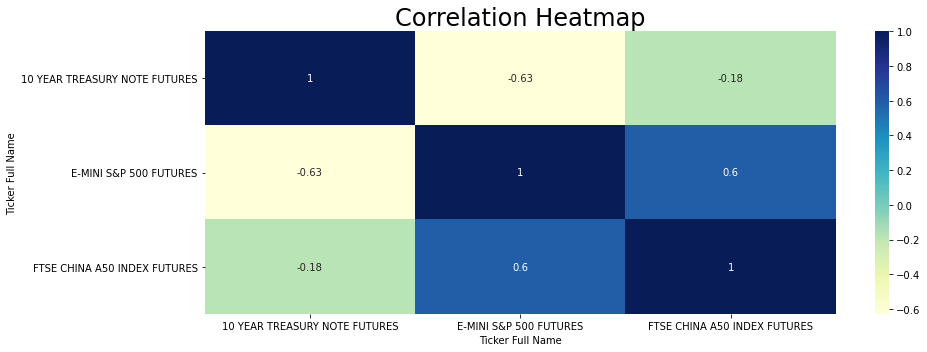

In [58]:
corr = quotes_df.corr()

sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap", fontsize=24)
plt.tight_layout()
plt.show()

Матрица корреляций, конечно, не говорит о лаговой связи инструментов, однако отметим, что наблюдается значительная положительная корреляция между фьючерсами на китайский индекс и фьючерсами на снп, а также значительная отрицательная корреляция между фьючерсами на снп и фьючерсами на трежерис.

С первых и последних пяти строк датасета видим (выше хитмапа корреляций), что присутствуют пропущенные значения. Напишем функцию для подсчета пропущенных значений и проверим наш датасет.

In [39]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [40]:
missing_zero_values_table(quotes_df)

Your selected dataframe has 3 columns and 684436 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Ticker Full Name,,,,,,
10 YEAR TREASURY NOTE FUTURES,0,165921,24.2,165921,24.2,float64
FTSE CHINA A50 INDEX FUTURES,0,118993,17.4,118993,17.4,float64
E-MINI S&P 500 FUTURES,0,11537,1.7,11537,1.7,float64


По фьючерсам на трежерис около четверти датасета являются пропущенными значениями.

Посмотрим на распределение пропущенных значений по времени. Для начала построим распределение пропущенных значений по месяцам.

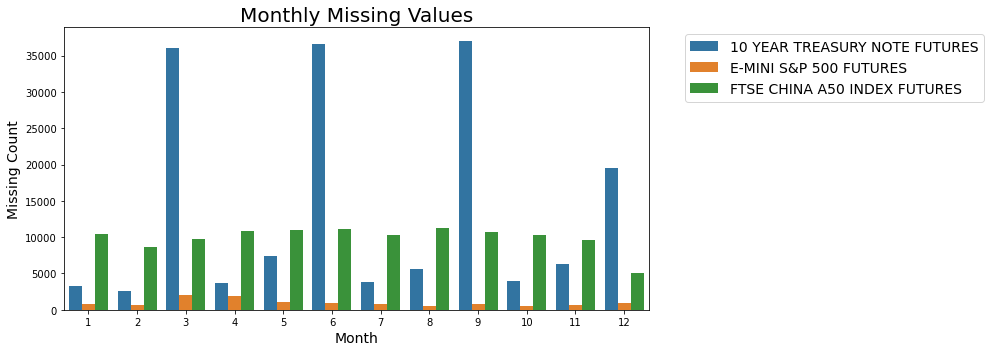

In [41]:
missing = quotes_df.isna()
missing['month'] = quotes_df.index.month
missing = missing.groupby('month').sum()

data_melted = missing.reset_index().melt(id_vars='month', var_name='Ticker Full Name', value_name='missing_count')

fig, ax = plt.subplots()
sns.barplot(x='month', y='missing_count', hue='Ticker Full Name', data=data_melted, ax=ax)
plt.title("Monthly Missing Values", fontsize=20, x=0.5, ha='center')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Missing Count", fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
plt.tight_layout()
plt.show()

Заметна значительная концентрация пропущенных значений по фьючерсам на трежерис в каждый третий месяц. Данный факт связан с экспирацией фьючерсов. Насколько я понимаю, связано это с низкой ликвидностью по данному инструменту, тк  месяц экспирации связан с поставкой андерлаинга и значительная часть участников рынка к месяцу экспирации фьючерсы на трежерис успели перероллить на более "длинные" фьючерсы. Стоит отдельно отметить 12ый месяц в году, где пропущенных значений в 1.5 - 2 раза меньше, чем в 3ий, 6ой и 9ый месяцы. Меньшее количество пропущенных значений связано с тем, что наши данные охватывают 23 месяца без декабря 21ого года и значительное количество пропущенных значений (в декабрь 21 года) просто не попало в датасет. Далле посмотрим на недельный срез (используем plotly, хотя графики и будут тяжелее, так как частота столбцов выше и будет удобнее определять недели).

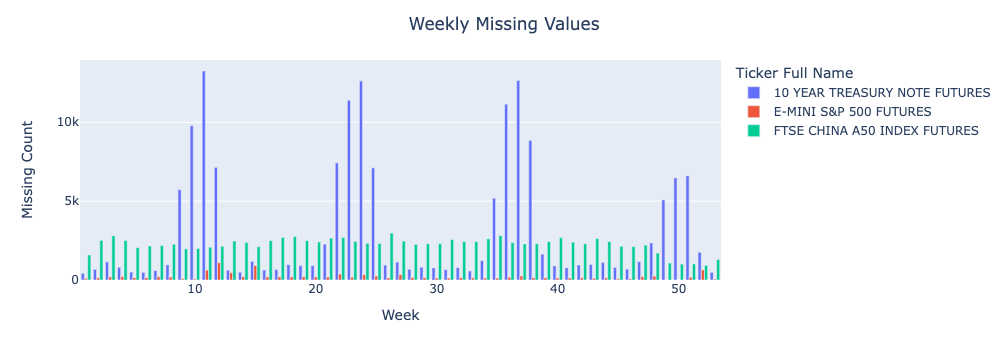

In [42]:
missing = quotes_df.isna()
missing['week'] = quotes_df.index.week
missing = missing.groupby('week').sum()

data_melted = missing.reset_index().melt(id_vars='week', var_name='Ticker Full Name', value_name='missing_count')

fig = px.bar(data_melted, x='week', y='missing_count', color='Ticker Full Name', barmode='group')
fig.update_layout(title={'text': 'Weekly Missing Values', 'x':0.5, 'xanchor': 'center'},
                  xaxis_title='Week', yaxis_title='Missing Count', dragmode = 'select')

fig.show()

Распределение пропущенных значений увеличивается к третьей неделе в месяце экспирации, насколько я знаю, связано это с тем, что даты экспирации фьючерсов приходятся на третью неделю месяца экспирации. Таким образом можем это объяснить снижением ликвидности инструмента к моменту экспирации. Посмотрим далее на срез по дням недели 11ой недели, где наблюдается максимальный пропуск значений.

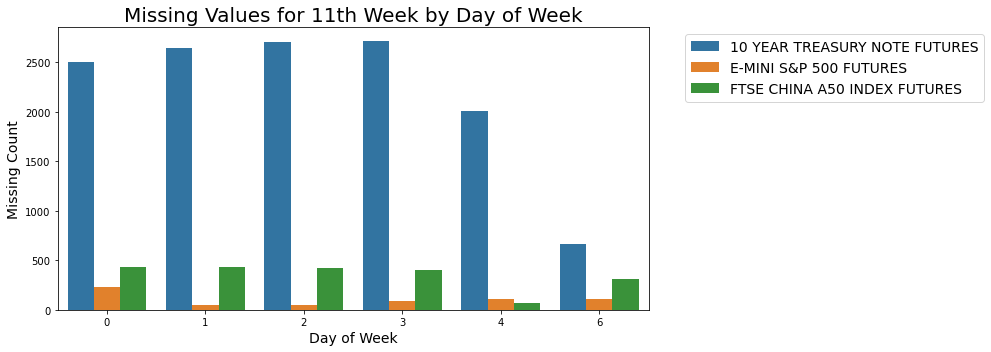

In [43]:
week11 = quotes_df[quotes_df.index.week == 11]
missing_week11 = week11.isna()
missing_week11['day_of_week'] = week11.index.dayofweek
missing_week11 = missing_week11.groupby('day_of_week').sum()

data_melted = missing_week11.reset_index().melt(id_vars='day_of_week', var_name='Ticker Full Name', value_name='missing_count')

fig, ax = plt.subplots()
sns.barplot(x='day_of_week', y='missing_count', hue='Ticker Full Name', data=data_melted, ax=ax)
plt.title("Missing Values for 11th Week by Day of Week", fontsize=20, x=0.5, ha='center')
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Missing Count", fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
plt.tight_layout()
plt.show()

Из интересного на данном графике можно отметить отсутствие пропусков в субботу - 5ый день недели, с учетом начала отсчета дней недели с нуля, и наличие пропусков в воскресенье, тк инструмент торгуется на биржах и в воскресенье (например СМЕ). Посмотрим далее на срез по часам.

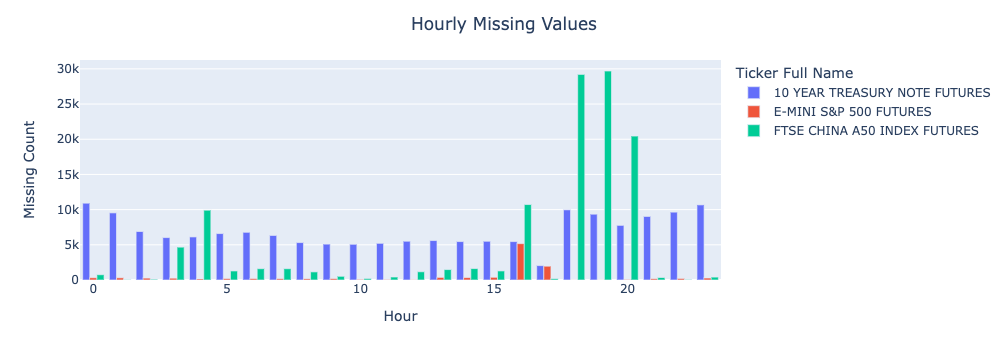

In [44]:
missing = quotes_df.isna()
missing['hour'] = quotes_df.index.hour
missing = missing.groupby('hour').sum()

data_melted = missing.reset_index().melt(id_vars='hour', var_name='Ticker Full Name', value_name='missing_count')

fig = px.bar(data_melted, x='hour', y='missing_count', color='Ticker Full Name', barmode='group')
fig.update_layout(title={'text': 'Hourly Missing Values', 'x':0.5, 'xanchor': 'center'},
                  xaxis_title='Hour', yaxis_title='Missing Count', dragmode = 'select')

fig.show()

Если смотреть по часам, то фьючерсы на снп500 имеют пропуски в 16ом и 17ом часах, это связано с приостановкой торгов на бирже в середине дня и переходом на зимнее вермя. Фьючерс на китайский рынок торгуется во временные отрезки 8:45 - 15:15, 16:30 - 6:00 по местному времени, учитывая 12 часовую разницу, а также зимнее время, получаем высокую концентрацию пропущенных значений во временные отрезки, как на графике.

Итак, пропущенные данные проанализировали. Далее избавимся от пропущенных данных с помощью интерполяции.

In [45]:
quotes_df.interpolate(inplace=True)

Также уберем нерабочие дни и перейдем к временным рядам с доходностями, тк матожидание ценовых временных рядов меняется со временем, а в дальнейшем процессе анализа нам будет нужна стационарность для проведения теста причинности Гренджера.

In [50]:
business_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())
left, right = quotes_df.index.min(), quotes_df.index.max()

df_returns = pd.DataFrame(index=pd.date_range(left, right, freq="1min"), columns = quotes_df.columns)
df_returns['date'] = pd.to_datetime(df_returns.index.date)
df_returns.loc[quotes_df.index, quotes_df.columns] = np.log(quotes_df / quotes_df.shift(-1))
df_returns = df_returns.loc[df_returns['date'].isin(
    pd.date_range(start=df_returns.loc[left, 'date'], end=df_returns.loc[right, 'date'], freq=business_days)), :]


df_returns.drop(columns=['date'], inplace=True)
df_returns.dropna(inplace=True)
display(df_returns)


Ticker Full Name,10 YEAR TREASURY NOTE FUTURES,E-MINI S&P 500 FUTURES,FTSE CHINA A50 INDEX FUTURES
2020-01-02 00:00:00,0.0,0.0,0.000343
2020-01-02 00:01:00,0.0,0.000077,0.000172
2020-01-02 00:02:00,0.0,0.0,0.000172
2020-01-02 00:03:00,0.0,0.0,-0.000515
2020-01-02 00:04:00,0.000125,0.0,-0.000172


Проверим датасет доходностей на пропущенные значения.

In [52]:
missing_zero_values_table(df_returns)

Your selected dataframe has 3 columns and 628018 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Ticker Full Name,,,,,,


Убедились в отсутствии пропущенных значений.

Одним из шагов анализа временных рядов на наличие зависимостей в данных является проведение анализ корреллограмм, выведем графики для ретернов для каждого из активов.

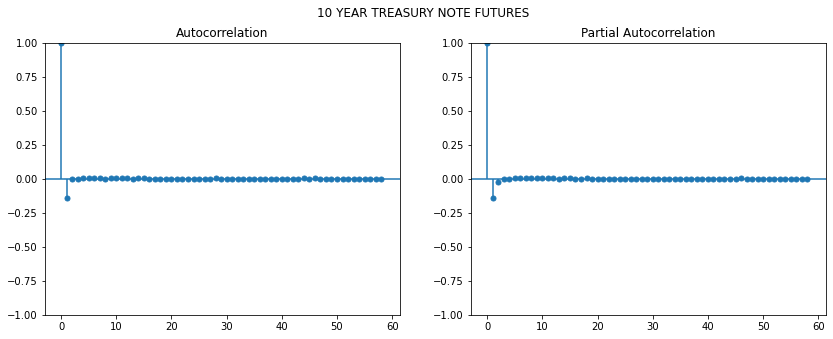

In [55]:
fig = plt.figure(figsize=(14,5))
fig.suptitle('10 YEAR TREASURY NOTE FUTURES', color ='black')
ax = fig.add_subplot(1,2,1)
plot_acf(df_returns['10 YEAR TREASURY NOTE FUTURES'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df_returns['10 YEAR TREASURY NOTE FUTURES'], ax=ax)
plt.show()

Здесь можем заметить некоторую зависимость от первого лага, в дальнейшей работе, возможно к этому вернемся.

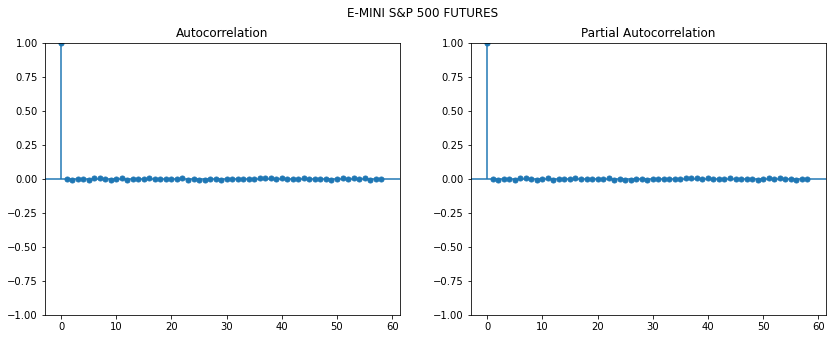

In [56]:
fig = plt.figure(figsize=(14,5))
fig.suptitle('E-MINI S&P 500 FUTURES', color ='black')
ax = fig.add_subplot(1,2,1)
plot_acf(df_returns['E-MINI S&P 500 FUTURES'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df_returns['E-MINI S&P 500 FUTURES'], ax=ax)
plt.show()

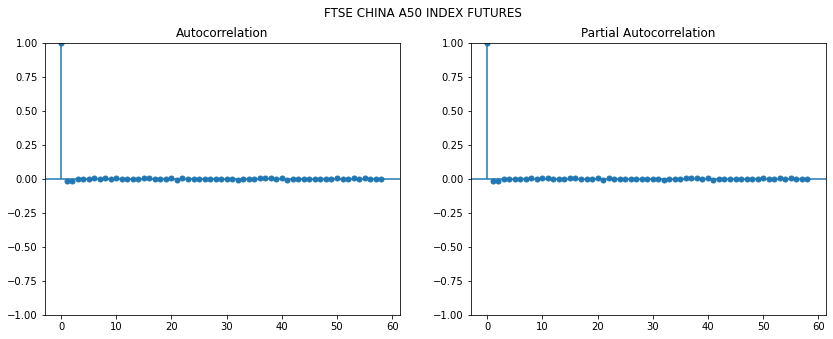

In [57]:
fig = plt.figure(figsize=(14,5))
fig.suptitle('FTSE CHINA A50 INDEX FUTURES', color ='black')
ax = fig.add_subplot(1,2,1)
plot_acf(df_returns['FTSE CHINA A50 INDEX FUTURES'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df_returns['FTSE CHINA A50 INDEX FUTURES'], ax=ax)
plt.show()

# Проверка наличия лаговых связей тестом Гренджера <a class="anchor" id="second-bullet"></a>

Для проверки наличия лаговых связей воспользуемся стандартным подходом - Тестом Гренджера. Возьмем реализацию теста из библиотеки statmodels.

Стоит отдельно отметить, что для теста Гренджера необходима стационарность рядов, поэтому будем проверять стационарность тестом Дики-Фуллера (ADF). Нулевая гипотеза теста - ряд нестационарен. 

Результатом теста Гренджера является набор четырех статистик, нулевая гипотеза данных статистик - отсутствие причнной связи между временными рядами. Будем считать, что наблюдается наличие причинности, когда отвергается нулевая гипотеза по всем 4ем статистикам.

Напишем функцию определения стационарности, будем использовать тест Дики-Фуллера.

In [69]:
def is_stationary(dataframe):
    stationary = True
    for column in dataframe.columns:
        test_result = adfuller(dataframe[column], autolag='AIC', maxlag=1)
        if test_result[1] >= 0.05:
            stationary = False
    return stationary

Проверять будем краткосрочные, среднесрочные и долгосрочные лаговые связи. Начнем с краткосрочных связей.

Создадим лист состоящий из пар активов, для которых будем искать связи

In [70]:
assets_pairs = [pair for pair in itertools.combinations(quotes_df.columns, 2)]
assets_pairs

[('10 YEAR TREASURY NOTE FUTURES', 'E-MINI S&P 500 FUTURES'),
 ('10 YEAR TREASURY NOTE FUTURES', 'FTSE CHINA A50 INDEX FUTURES'),
 ('E-MINI S&P 500 FUTURES', 'FTSE CHINA A50 INDEX FUTURES')]

Далее напишем функцию, которая будет находить минимальный лаг для пары фьючерсов в тесте Гренджера. 

In [80]:
def shortest_lag(ts_pair, assets_pair, stats=['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'], base_lag=30):
    shortest_lag, pair_col, pairs = np.nan, assets_pair[-1], [assets_pair, assets_pair[::-1]]
    
    for col in pairs:
        try:            
            gc_res = grangercausalitytests(ts_pair[list(col)], maxlag=base_lag, verbose=False)
            p_values = [gc_res[l][0][statistic][1] for l in range(1, base_lag + 1) for statistic in stats]
            p_values = np.array(p_values).reshape(base_lag, len(stats))
            p_values_max = p_values.max(axis=1)
            new_shortest_lag = np.where(p_values_max < 0.05)[0][0] + 1
            if np.isnan(shortest_lag) or new_shortest_lag < shortest_lag:
                shortest_lag, pair_col = new_shortest_lag, col[-1]
        except:
            pass
    
    return shortest_lag, pair_col

### Краткосрочные связи

Тестировать будем только ряды длиной более 90 минут, тк лаг 30 минут и остается длина двух лагов. В случае наличия причинной связи для обоих фьючерсов в паре, лидером будем брать тот актив, чей лаг меньше.

In [102]:
result = {}
df_returns['date'] = df_returns.index.date

for pair in assets_pairs:
    result[pair] = pd.DataFrame(index=df_returns['date'].unique(), 
                                columns=["leader is " + pair[-1] + " in a following № of cases:"] + 
                                ["leader is " + pair[0] + " in a following № of cases:"])
    
    for date in tqdm(df_returns['date'].unique()):
        test_data = df_returns.loc[df_returns['date'] == date, pair]
        if len(test_data.index) > 90:
            if is_stationary(test_data):
                min_lag, leading_col = shortest_lag(test_data, pair)
                result[pair].loc[date, ["leader is " + leading_col + " in a following № of cases:"]] = min_lag

for key in result.keys():
    print((result[key].fillna(0) > 0).sum(axis=0))

100%|██████████| 481/481 [02:49<00:00,  2.84it/s]

leader is E-MINI S&P 500 FUTURES in a following № of cases:           325
leader is 10 YEAR TREASURY NOTE FUTURES in a following № of cases:    105
dtype: int64
leader is FTSE CHINA A50 INDEX FUTURES in a following № of cases:     160
leader is 10 YEAR TREASURY NOTE FUTURES in a following № of cases:     50
dtype: int64
leader is FTSE CHINA A50 INDEX FUTURES in a following № of cases:     62
leader is E-MINI S&P 500 FUTURES in a following № of cases:          186
dtype: int64


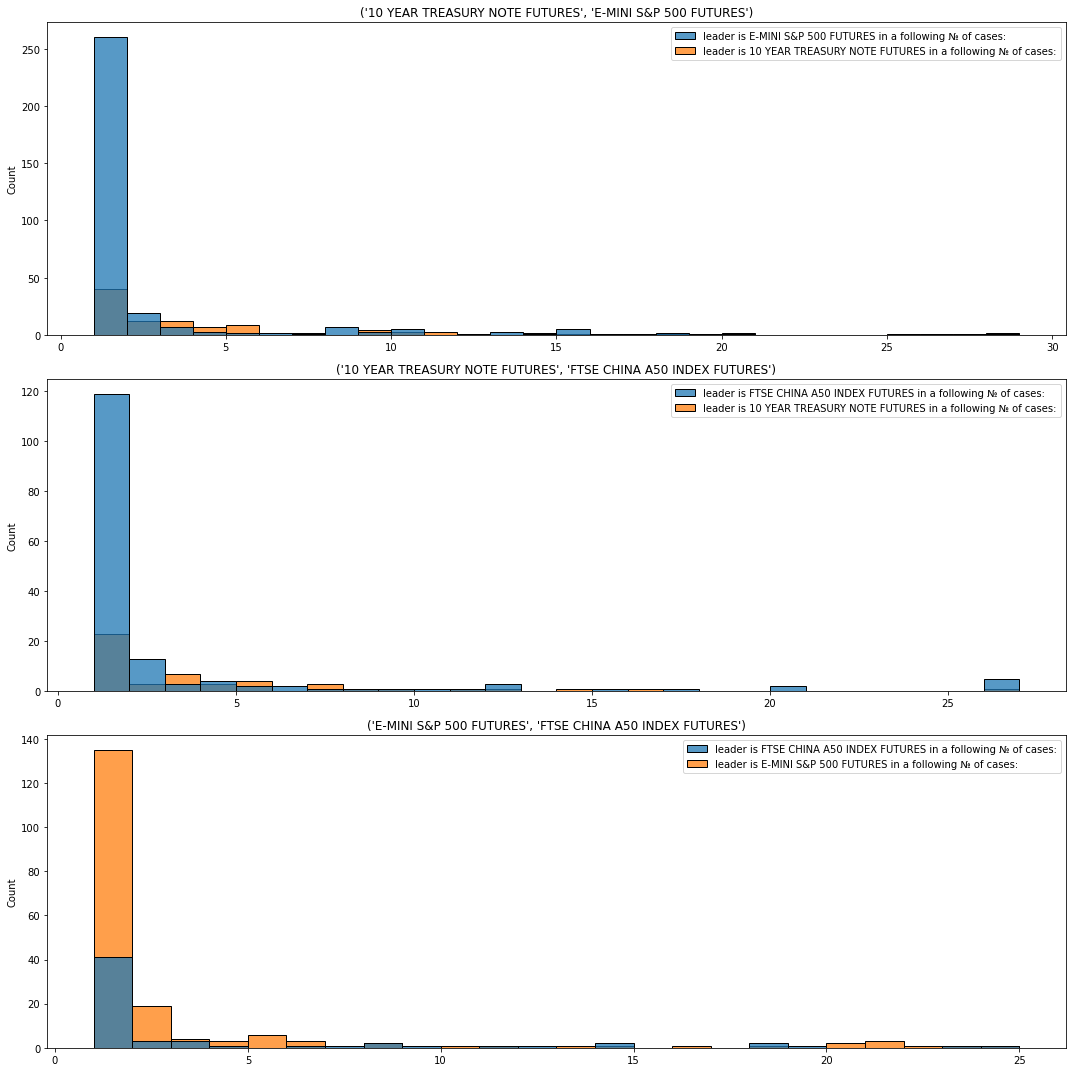

In [103]:
keys = list(result.keys())
n_plots = len(keys)

fig, ax = plt.subplots(nrows=n_plots, ncols=1, figsize=(15, 15))

for i, key in enumerate(keys):
    sns.histplot(data=result[key], color='skyblue', binwidth=1, ax=ax[i])
    ax[i].set_title(str(key))

plt.tight_layout()

Выводы по исследованию краткосрочной лаговой зависимости. Стоит заметить, что абсолютной лаговой зависимости не наблюдается: лидирующий актив является причиной для актива фолловера примерно в 75% случаев и в 25% случаев наблюдается обратная зависимость.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES. Наблюдается лаговая зависимость и фьючерс E-MINI S&P 500 FUTURES является лидером, а фьючерс 10 YEAR TREASURY NOTE FUTURES - фолловером.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается лаговая зависимость и фьючерс FTSE CHINA A50 INDEX FUTURES является лидером, а фьючерс 10 YEAR TREASURY NOTE FUTURES - фолловером.

Фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается лаговая зависимость и фьючерс E-MINI S&P 500 FUTURES  является лидером, а фьючерс FTSE CHINA A50 INDEX FUTURES  - фолловером.

### Долгосрочные связи

Данные фьючерсы торгуются 6 дней в неделю. Поэтому максимальный лаг будет 6 дней. Работать будем с дневными доходностями, тк мы располагаем только минутными доходностями (как производными от цен активов) и не располагаем объемами торгов, то будем просто суммировать доходности внутри дня, и доходностью за день будем считать сумму минутных доходностей за этот день. 

In [114]:
df_daily_returns = df_returns.copy()
df_daily_returns['date'] = df_daily_returns.index.date
df_daily_returns = df_daily_returns.groupby(['date']).sum()
display(df_daily_returns)

Ticker Full Name,10 YEAR TREASURY NOTE FUTURES,E-MINI S&P 500 FUTURES,FTSE CHINA A50 INDEX FUTURES
date,,,
2020-01-02,-0.005338,0.001004,0.006538
2020-01-03,-0.004353,0.005344,0.003054
2020-01-06,0.002659,-0.007176,0.002070
2020-01-07,-0.002899,0.008570,0.006756
2020-01-08,0.005441,-0.012024,-0.005720
...,...,...,...
2021-11-23,-0.001324,0.000748,-0.000128
2021-11-24,0.001801,-0.007401,0.004093
2021-11-26,-0.002755,0.010260,0.002573


Будем рассматривать временные ряды длиной в квартал (в 3х месяцах будет 78 торговых дней) и использовать скользящее окно в торговую неделю (6 дней). В случае наличия причинной связи для обоих фьючерсов в паре, лидером будем брать тот актив, чей лаг меньше.

In [110]:
result_long = {}
index_result = range(78, df_daily_returns.shape[0], 6)

for pair in assets_pairs:
    result_long[pair] = pd.DataFrame(index=df_daily_returns.index[index_result], 
                                     columns=["leader is " + pair[-1] + " in a following № of cases:"] + 
                                     ["leader is " + pair[0] + " in a following № of cases:"])
    
    for ind_date in tqdm(index_result):
        test_data = df_daily_returns.loc[df_daily_returns.index[ind_date - 78]:df_daily_returns.index[ind_date], pair]
        if is_stationary(test_data): 
            min_lag, leading_col = shortest_lag(test_data, pair, lag=6)
            result_long[pair].loc[df_daily_returns.index[ind_date], 
                                  ["leader is " + leading_col + " in a following № of cases:"]] = min_lag
    

for key in result_long.keys():
    print(result_long[key].sum(axis=0))

100%|██████████| 68/68 [00:02<00:00, 33.40it/s]

leader is E-MINI S&P 500 FUTURES in a following № of cases:           44
leader is 10 YEAR TREASURY NOTE FUTURES in a following № of cases:    19
dtype: object
leader is FTSE CHINA A50 INDEX FUTURES in a following № of cases:     31
leader is 10 YEAR TREASURY NOTE FUTURES in a following № of cases:    32
dtype: object
leader is FTSE CHINA A50 INDEX FUTURES in a following № of cases:    23
leader is E-MINI S&P 500 FUTURES in a following № of cases:          47
dtype: object


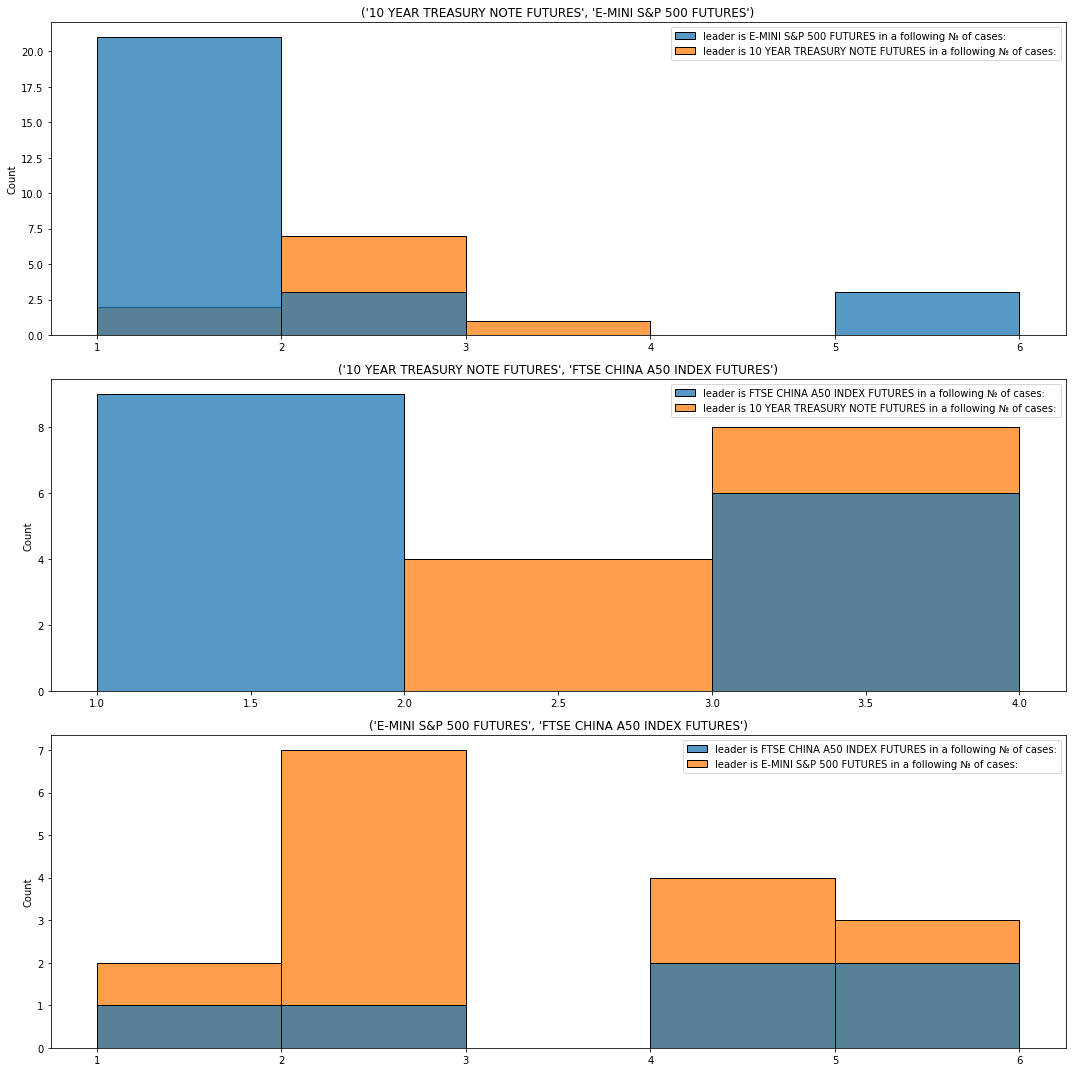

In [111]:
keys = list(result_long.keys())
n_plots = len(keys)

fig, ax = plt.subplots(nrows=n_plots, ncols=1, figsize=(15, 15))

for i, key in enumerate(keys):
    sns.histplot(data=result_long[key], color='skyblue', binwidth=1, ax=ax[i])
    ax[i].set_title(str(key))

plt.tight_layout()

Выводы по исследованию долгосрочной лаговой зависимости. Стоит заметить, что абсолютной лаговой зависимости не наблюдается: лидирующий актив является причиной для актива фолловера примерно в 70% случаев и в 30% случаев наблюдается обратная зависимость.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES. Наблюдается лаговая зависимость и фьючерс E-MINI S&P 500 FUTURES является лидером, а фьючерс 10 YEAR TREASURY NOTE FUTURES - фолловером.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES. Долгосрочной лаговой зависимости не наблюдается.

Фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается лаговая зависимость и фьючерс E-MINI S&P 500 FUTURES  является лидером, а фьючерс FTSE CHINA A50 INDEX FUTURES  - фолловером.

### Среднесрочные связи

Логично было бы поискать лаговые зависимости в таймфреймах между минутным и дневными. Возьмем часовой таймфрейм. Доходностью за час будет также сумма минутных доходностей внутри часа.

In [113]:
df_hourly_returns = df_returns.copy()
df_hourly_returns['date'] = df_hourly_returns.index.date
df_hourly_returns['hour'] = df_hourly_returns.index.hour
df_hourly_returns = df_hourly_returns.groupby(['date', 'hour']).sum()
display(df_hourly_returns)

Ticker Full Name  10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
date       hour                                                           
2020-01-02 0                          -0.000241               -0.000077   
           1                           0.000241                0.000077   
           2                           0.000733               -0.000925   
           3                           0.000483               -0.001310   
           4                          -0.000242               -0.000616   
...                                         ...                     ...   
2021-11-30 19                         -0.000594                0.001473   
           20                          0.001075               -0.003054   
           21                          0.000023               -0.001741   
           22                         -0.000216                0.000761   
           23                         -0.000165               -0.002228   

Ticker Full Name  FTSE CHINA A50 INDEX FUTURES  
date       hour                                 
2020-01-02 0                         -0.001200  
           1                          0.003088  
           2                         -0.001888  
           3                         -0.001008  
           4                         -0.000534  
...                                        ...  
2021-11-30 19                         0.000707  
           20                         0.000729  
           21                        -0.002737  
           22                        -0.001041  
           23                        -0.000650  

[10948 rows x 3 columns]

Будем рассматривать временные ряды длиной в половину торговой недели (3 дня) и использовать скользящее окно в 6 часов. В случае наличия причинной связи для обоих фьючерсов в паре, лидером будем брать тот актив, чей лаг меньше.

In [116]:
result_medium = {}
index_result = range(72, df_hourly_returns.shape[0], 6)

for pair in assets_pairs:
    result_medium[pair] = pd.DataFrame(index=df_hourly_returns.index[index_result], 
                                     columns=["leader is " + pair[-1] + " in a following № of cases:"] + 
                                     ["leader is " + pair[0] + " in a following № of cases:"])
    
    for ind_date in tqdm(index_result):
        test_data = df_hourly_returns.loc[df_hourly_returns.index[ind_date - 72]:df_hourly_returns.index[ind_date], pair]
        if is_stationary(test_data): 
            min_lag, leading_col = shortest_lag(test_data, pair, lag=6)
            result_medium[pair].loc[df_hourly_returns.index[ind_date], 
                                  ["leader is " + leading_col + " in a following № of cases:"]] = min_lag
    

for key in result_medium.keys():
    print(result_medium[key].sum(axis=0))

100%|██████████| 1813/1813 [00:49<00:00, 36.83it/s]

leader is E-MINI S&P 500 FUTURES in a following № of cases:            612
leader is 10 YEAR TREASURY NOTE FUTURES in a following № of cases:    1061
dtype: object
leader is FTSE CHINA A50 INDEX FUTURES in a following № of cases:     380
leader is 10 YEAR TREASURY NOTE FUTURES in a following № of cases:    362
dtype: object
leader is FTSE CHINA A50 INDEX FUTURES in a following № of cases:    155
leader is E-MINI S&P 500 FUTURES in a following № of cases:          543
dtype: object


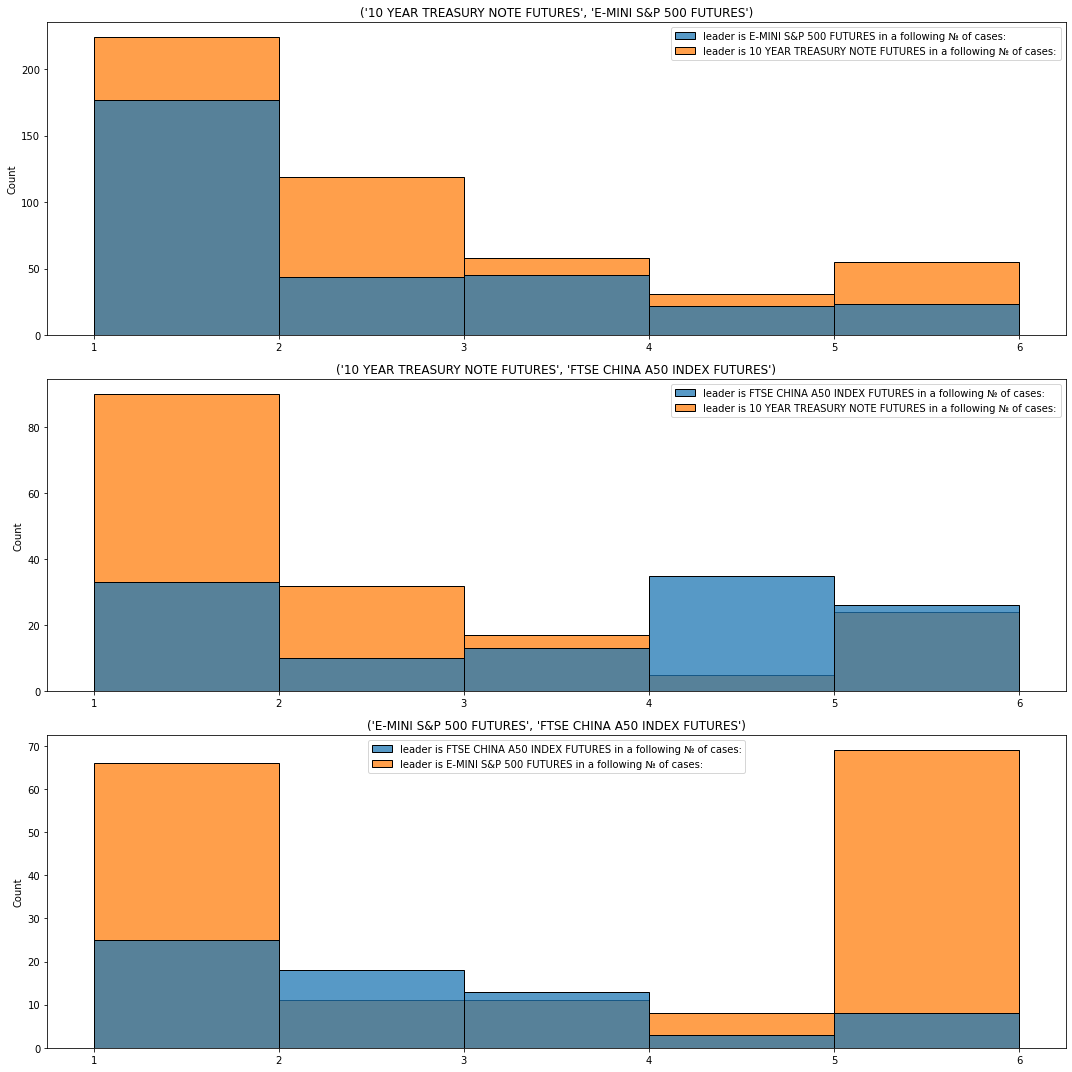

In [117]:
keys = list(result_medium.keys())
n_plots = len(keys)

fig, ax = plt.subplots(nrows=n_plots, ncols=1, figsize=(15, 15))

for i, key in enumerate(keys):
    sns.histplot(data=result_medium[key], color='skyblue', binwidth=1, ax=ax[i])
    ax[i].set_title(str(key))

plt.tight_layout()

Выводы по исследованию среднесрочной лаговой зависимости. Стоит заметить, что абсолютной лаговой зависимости в парах активов не наблюдается.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES. Наблюдается попеременная лаговая зависимость и фьючерс 10 YEAR TREASURY NOTE FUTURES является чаще лидером, а фьючерс E-MINI S&P 500 FUTURES - чаще фолловером.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES. Среднесрочной лаговой зависимости не наблюдается.

Фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается лаговая зависимость и фьючерс E-MINI S&P 500 FUTURES является лидером, а фьючерс FTSE CHINA A50 INDEX FUTURES - фолловером.

# Альтернативные методы определения лаговых связей <a class="anchor" id="third-bullet"></a>

В рамках нашей задачи хотелось бы посмотреть на результаты альтернативных методов определения лаговых связей. Согласно относительно недавнему "мета-анализу", посвященному нашей теме (https://aip.scitation.org/doi/full/10.1063/5.0053519), определение лаговых связей по Гренджеру относительно успешно справляется с задачей в системах, переменные которых можно рассматривать не как единое целое, а по частям (линейная стохастическая система).

Есть и другие подходы к данной задаче. Например, можем отнестись к системе, как к динамически связанной, те к системе в которой возможен случай, когда и X, и Y, являются причинами друг друга. В такой ситуации мы можем оценить точности предсказаний одними процессами других и прийти к заключению, какой из процессов более точен в определении другого. В случае работы с нашей системой, как с динамически связанной, зарекомендовавшим себя является метод Convergent cross mapping.

Данный метод строится на идее алгоритма KNN. Смысл алгоритма для двух процессов X и Y: если k ближайших соседей из выборки X_train для каждой точки y_i из выборки Y_test достаточно хорошо их предсказывают, то можно говорить, что процесс X является причиной Y, и наоборот.


Для начала рассмотрим пример пары фьючерсов E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. В данной паре в предыдущем методе определения лаговых связей на всех трех временных перспективах лидером был фьючерс E-MINI S&P 500.


In [152]:
snp, ftse = df_returns.iloc[:100000, 1], df_returns.iloc[:100000, 2]
e1, e2 = ccm.Embed(snp), ccm.Embed(ftse)
lag, embed = 1, 5

Возьмем для примера работы алгоритма первые 100т точек датафрейма доходностей. Также стоит чуть больше сказать о гиперпараметрах алгоритма, с которым будем работать далее.

Гиперпараметр "embed" определяет количество измерений или переменных, используемых для представления фазового пространства временного ряда. Более высокое значение "embed" приводит к более высокоразмерному фазовому пространству, которое может захватывать более сложные отношения между переменными.

Гиперпараметр "lag" определяет временную задержку, используемую для построения фазового пространства. Более высокое значение "lag" приводит к более разделенному представлению переменных в фазовом пространстве, что может улучшить обнаружение связей между ними.

Далее разобъем датасет на тестовую и тренировочную выборки и обучим модель. Стоит отметить параметр lib_lens, который показывает количество объектов тренировочного датасета, участвующего в определении ближайших соседей для предсказания объекта тестового датасета. С целью демонстрации сходимости модели в процессе обучения будем планомерно увеличивать число объектов из тренировочного датасета.


In [153]:
X1, X2 = e1.embed_vectors_1d(lag, embed), e2.embed_vectors_1d(lag, embed)

snp_train, snp_test, ftse_train, ftse_test = ccm.utilities.train_test_split(X1,X2, percent=.7)
CCM = ccm.CCM()

train_length = len(snp_train)
lib_lens = np.arange(400, train_length, train_length/200, dtype='int')

CCM.fit(snp_train, ftse_train)

Text(0, 0.5, 'R^2')

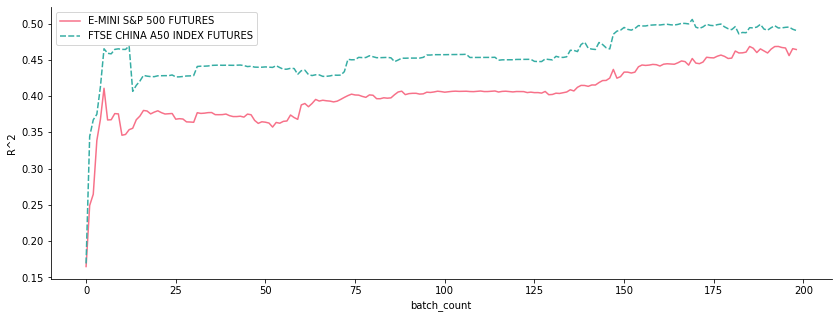

In [154]:
snp_pred, ftse_pred = CCM.predict(snp_test, ftse_test, lib_lengths=lib_lens)
sc1, sc2 = CCM.score()

df_score = pd.DataFrame(columns=['E-MINI S&P 500 FUTURES', 'FTSE CHINA A50 INDEX FUTURES'])
df_score['E-MINI S&P 500 FUTURES'] = sc1
df_score['FTSE CHINA A50 INDEX FUTURES'] = sc2

sns.lineplot(data=df_score, ci=None, palette='husl')
sns.despine()
plt.xlabel("batch_count")
plt.ylabel("R^2")

Как можем заметить, R^2 больше нуля и стремится к 0.5 с увеличением числа точек, выходя на плато. Данный результат означает наличие влияния активов друг на друга, причем фьючерс FTSE CHINA A50 INDEX FUTURES объясняется фьючерсом E-MINI S&P 500 FUTURES сильнее, схожий результат мы наблюдали по итогам теста Гренджера. Стоит отметить, что временной ряд доходностей каждого актива здесь рассматривается в качестве процессов динамической системы.

Далее напишем функцию, которая будет принимать на вход гиперпараметры "lag" и "embed", преобразованные временные ряды и выдавать на выходе скоры R^2 для пар активов.

In [157]:
def R2_score(e1, e2, lag, embed, isLong=False):
    
    X1 = e1.embed_vectors_1d(lag, embed)
    X2 = e2.embed_vectors_1d(lag, embed)

    x1_train, x1_test, x2_train, x2_test = ccm.utilities.train_test_split(X1,X2, percent=.8)
    CCM = ccm.CCM()
    train_length = len(x1_train)
    lib_lens = [train_length] if not isLong else np.arange(100, train_length, train_length/50, dtype='int')

    CCM.fit(x1_train, x2_train)
    x1_pred, x2_pred = CCM.predict(x1_test, x2_test, lib_lengths=lib_lens)

    sc1, sc2 = CCM.score()
    return [sc1[0], sc2[0]] if not isLong else [sc1, sc2]

### Краткосрочные связи

Для определения краткосрочных связей возьмем данные минутных доходностей. Будем проходить по временным рядам скользящим окном размером в месяц. Далее для каждой пары активов построим график R^2 от времени, чтобы посмотреть как менялась причинная (лаговая) связь в динамике. По гиперпараметрам: будем искать наибольший score при lag = [1,2,3] (в предположении, что ближайшие данные имеют более значимую предсказательную силу) и embed = [2,3,4,5].

In [187]:
lag = 1
score_data = {}
for pair in assets_pairs:
    score_data[str(pair)] = pd.DataFrame(columns=pair)

step = 23 * 5 # 23 месяца * 5 частей (4 тренировочной части и 1 тестовая)
batch_count = df_returns.shape[0] // step

for pair in assets_pairs:
    for i in tqdm(range(step - 4)):
        sc1_max, sc2_max = 0, 0        
        
        df_returns_temp = df_returns.iloc[(i*batch_count):((i+5)*batch_count), :]
        e1 = ccm.Embed(df_returns_temp[pair[0]])
        e2 = ccm.Embed(df_returns_temp[pair[1]])
        
        for embed in range(2, 6):
            for lag in range(1,4):
                score = R2_score(e1, e2, lag, embed)
                sc1_max = score[0] if score[0] > sc1_max else sc1_max
                sc2_max = score[1] if score[1] > sc2_max else sc2_max
        
        score_data[str(pair)].loc[df_returns.iloc[i*batch_count, -1], :] = [sc1_max, sc2_max]

100%|██████████| 111/111 [1:41:54<00:00, 55.09s/it]


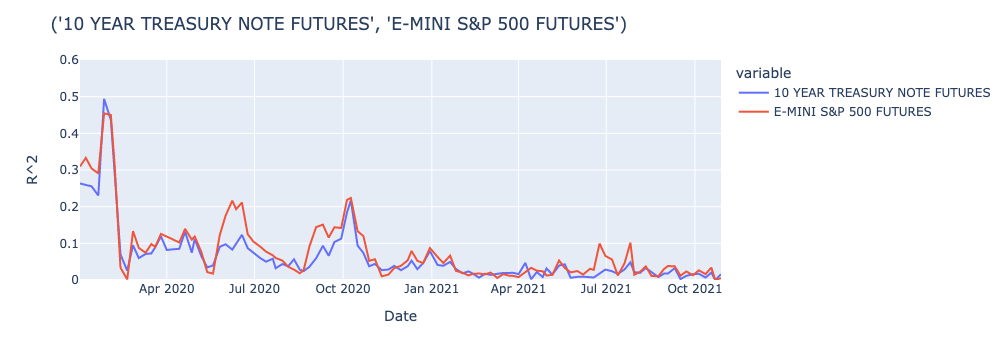

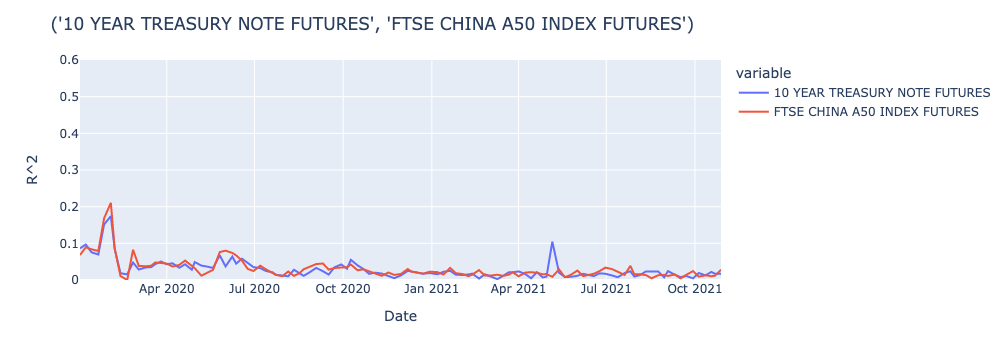

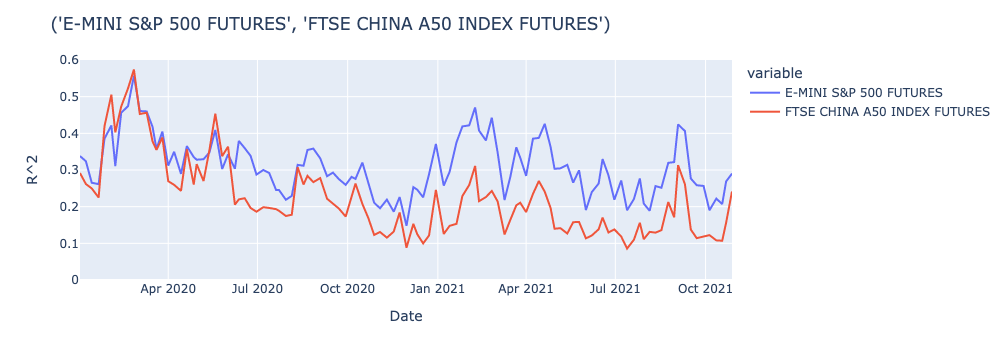

In [189]:
for pair in assets_pairs:
    df = score_data[str(pair)]
    fig = px.line(df, x=df.index, y=df.columns, labels={'index': 'Date', 'value': 'R^2'})
    fig.update_layout(title=str(pair), yaxis_title='R^2', yaxis=dict(range=[0, 0.6]))
    fig.show()

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES. Наблюдалась двусторонняя причинная связь в январе и начале февраля 2020 года, а также с конца сентября по середину октября 2020 года. Так же стоит отметить, что в июне и сентябре 2020 фьючерс E-MINI S&P 500 FUTURES являлся фолловером, а 10 YEAR TREASURY NOTE FUTURES - лидером. В остальное время причинная связь отсутствовала (на низком уровне).

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES. В данной паре активов скор сохранялся на низком уровне, что говорит об отсутствии лаговой связи.

Фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается явная лаговая зависимость обоих инструментов друг от друга, причем E-MINI S&P 500 FUTURES объясняется FTSE CHINA A50 INDEX FUTURES с большей силой, т.е. E-MINI S&P 500 FUTURES - фолловер, а FTSE CHINA A50 INDEX FUTURES - лидер. Следует отметить, что начиная с 2021 года E-MINI S&P 500 FUTURES слабо влияет на FTSE CHINA A50 INDEX FUTURES, что говорит об односторонней причинности.

### Среднесрочные связи

Среднесрочную связь проверим на часовых данных доходностей. Пройдем по данным скользящим окном длиной в квартал. В конце для каждой пары построим график R^2 от времени, чтобы посмотреть как менялась причинная (лаговая) связь в динамике.

In [190]:
lag = 1
score_data_medium = {}
for pair in assets_pairs:
    score_data_medium[str(pair)] = pd.DataFrame(columns=pair)

step = 8 * 5 # 8 кварталов * 5 частей (4 тренировочной части и 1 тестовая)
batch_count = df_hourly_returns.shape[0] // step

for pair in assets_pairs:
    for i in tqdm(range(step - 4)):
        sc1_max, sc2_max = 0, 0        
        
        returns_temp = df_hourly_returns.iloc[(i*batch_count):((i+5)*batch_count), :]
        e1, e2 = ccm.Embed(returns_temp[pair[0]]), ccm.Embed(returns_temp[pair[1]])
        
        for embed in range(2, 6):
            for lag in range(1,4):
                score = R2_score(e1, e2, lag, embed)
                sc1_max = score[0] if score[0] > sc1_max else sc1_max
                sc2_max = score[1] if score[1] > sc2_max else sc2_max
        
        score_data_medium[str(pair)].loc[df_hourly_returns.index[i*batch_count][0], :] = [sc1_max, sc2_max]

100%|██████████| 36/36 [01:17<00:00,  2.16s/it]


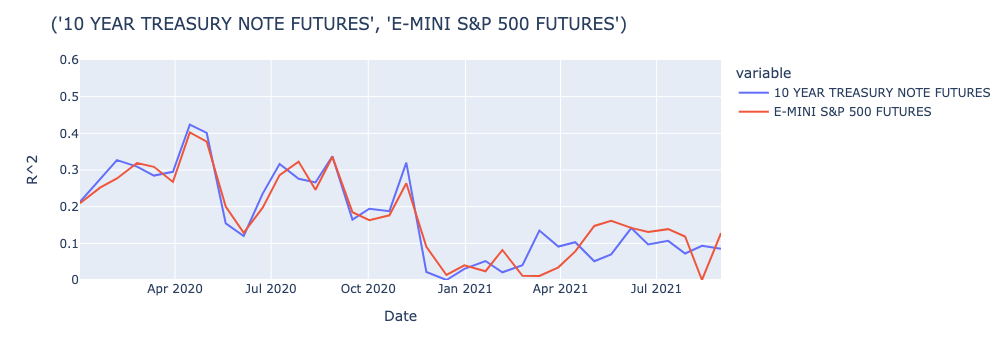

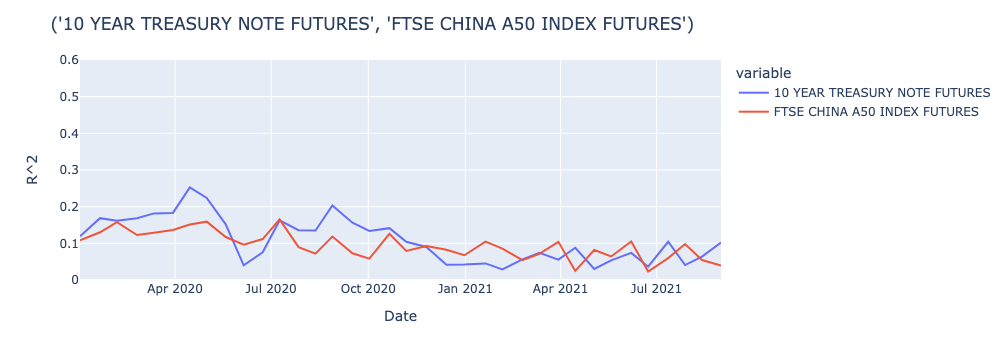

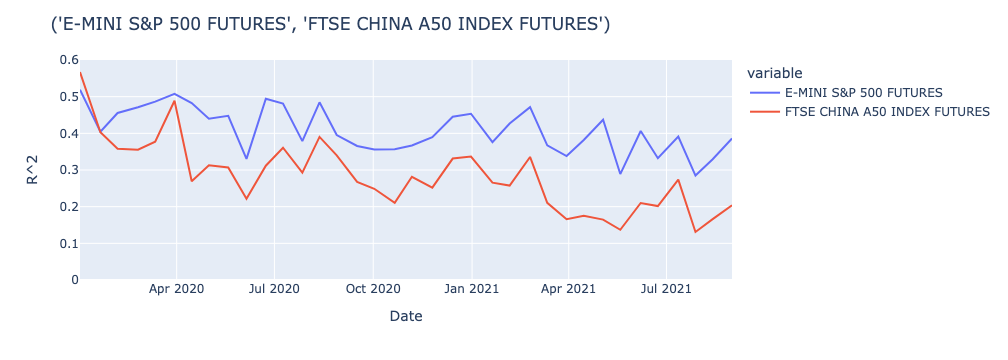

In [191]:
for pair in assets_pairs:
    df = score_data_medium[str(pair)]
    fig = px.line(df, x=df.index, y=df.columns, labels={'index': 'Date', 'value': 'R^2'})
    fig.update_layout(title=str(pair), yaxis_title='R^2', yaxis=dict(range=[0, 0.6]))
    fig.show()

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES. Оба инструмента являются причинами друг друга с равной силой в течение 2020 года с периодами отсутствия причинности с середины мая по середину июня 2020 года и в декабре 2020 года. В 2021 году скор на низком уровне (< 0.15), что говорит об отсутствии лаговой связи.

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES. В данной паре активов скор сохранялся на низком уровне, что говорит об отсутствии лаговой связи.

Фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается явная лаговая зависимость обоих инструментов друг от друга, причем "E-MINI S&P 500 FUTURES" объясняется "FTSE CHINA A50 INDEX FUTURES" с большей силой, т.е. E-MINI S&P 500 FUTURES - фолловер, а FTSE CHINA A50 INDEX FUTURES - лидер.

### Долгосрочные связи

Долгосрочную лаговую связь проверим на дневных данных доходностей. Так как точек не так много, то будем постепенно увеличивать обучающую выборку, как это было сделано в примере.

In [192]:
lag = 1
score_data_long = {}
for pair in assets_pairs:
    score_data_long[str(pair)] = pd.DataFrame(columns=pair)

for pair in assets_pairs:
    sc1_max, sc2_max = 0,0
    e1, e2 = ccm.Embed(df_daily_returns[pair[0]]), ccm.Embed(df_daily_returns[pair[1]])

    for embed in range(2, 6):
        for lag in range(1,4):
            score = R2_score(e1, e2, lag, embed, isLong=True)
            sc1_max = np.array(score[0]) if np.array(score[0]).mean() > np.mean(sc1_max) else sc1_max
            sc2_max = np.array(score[1]) if np.array(score[1]).mean() > np.mean(sc2_max) else sc2_max

    score_data_long[str(pair)][pair[0]] = sc1_max
    score_data_long[str(pair)][pair[1]] = sc2_max

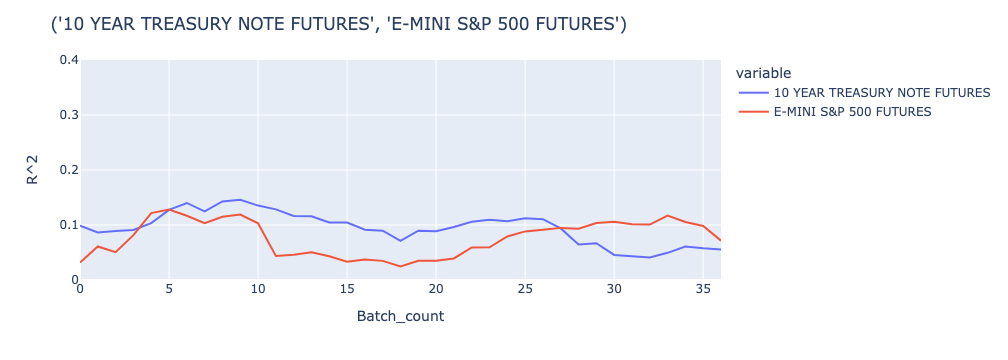

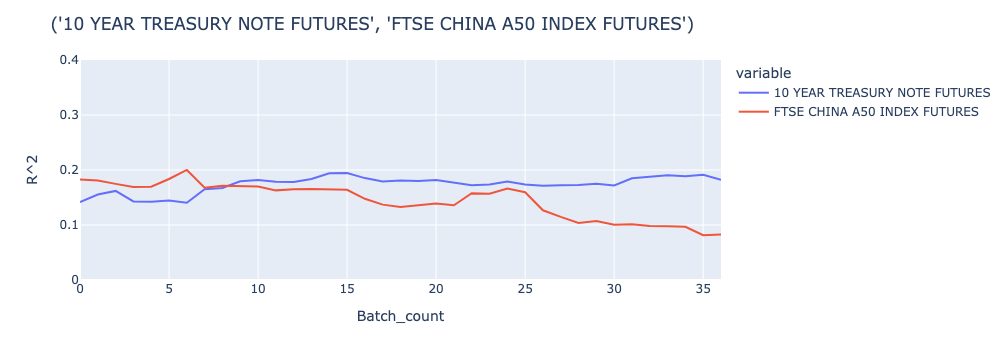

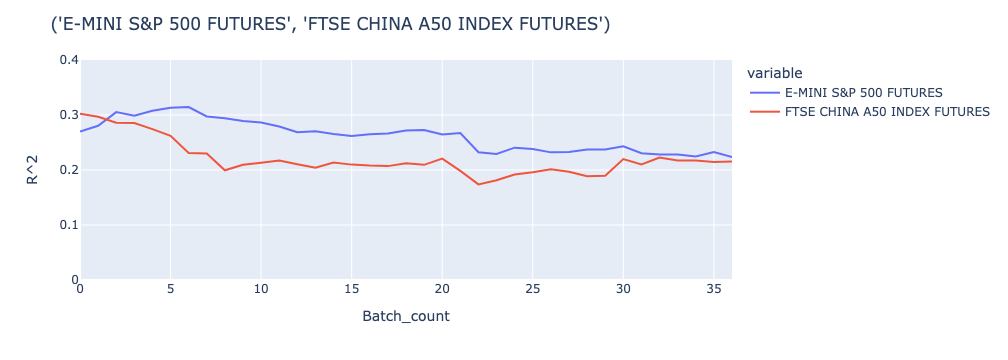

In [193]:
for pair in assets_pairs:
    df = score_data_long[str(pair)]
    fig = px.line(df, x=df.index, y=df.columns, labels={'index': 'Batch_count', 'value': 'R^2'})
    fig.update_layout(title=str(pair), yaxis_title='R^2', yaxis=dict(range=[0, 0.4]))
    fig.show()

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и E-MINI S&P 500 FUTURES. В данной паре активов скор сохранялся на низком уровне, что говорит об отсутствии лаговой связи. 

Фьючерсы 10 YEAR TREASURY NOTE FUTURES и FTSE CHINA A50 INDEX FUTURES. В данной паре активов скор сохранялся на низком уровне, что говорит об отсутствии лаговой связи. 

Фьючерсы E-MINI S&P 500 FUTURES и FTSE CHINA A50 INDEX FUTURES. Наблюдается явная лаговая зависимость 'E-MINI S&P 500 FUTURES' от 'FTSE CHINA A50 INDEX FUTURES'. т.е. E-MINI S&P 500 FUTURES - фолловер, а FTSE CHINA A50 INDEX FUTURES - лидер.

# Выводы <a class="anchor" id="fourth-bullet"></a>

В данной работе мы анализировали пары фьючерсов на наличие лаговых связей. В анализе участвовали пары активов: ('10 YEAR TREASURY NOTE FUTURES', 'E-MINI S&P 500 FUTURES'), ('10 YEAR TREASURY NOTE FUTURES', 'FTSE CHINA A50 INDEX FUTURES') и ('E-MINI S&P 500 FUTURES', 'FTSE CHINA A50 INDEX FUTURES'). С целью определения наличия связей мы использовали тест Гренджера и метод Convergent cross mapping.

#### Результаты теста Гренджера:

Результаты для краткосрочной лаговой связи по Гренджеру:
 1. E-MINI S&P 500 FUTURES является лидером, а 10 YEAR TREASURY NOTE FUTURES - фолловером в паре (10 YEAR TREASURY NOTE FUTURES, E-MINI S&P 500 FUTURES)
 2. FTSE CHINA A50 INDEX FUTURES является лидером, а 10 YEAR TREASURY NOTE FUTURES - фолловером в паре (10 YEAR TREASURY NOTE FUTURES, FTSE CHINA A50 INDEX FUTURES)
 3. E-MINI S&P 500 FUTURES является лидером, а FTSE CHINA A50 INDEX FUTURES - фолловером в паре (E-MINI S&P 500 FUTURES, FTSE CHINA A50 INDEX FUTURES)

Результаты для долгосрочной лаговой связи по Гренджеру:
 1. E-MINI S&P 500 FUTURES является лидером, а 10 YEAR TREASURY NOTE FUTURES - фолловером в паре (10 YEAR TREASURY NOTE FUTURES, E-MINI S&P 500 FUTURES)
 2. В паре (10 YEAR TREASURY NOTE FUTURES, FTSE CHINA A50 INDEX FUTURES) лаговой связи не наблюдается
 3. E-MINI S&P 500 FUTURES является лидером, а FTSE CHINA A50 INDEX FUTURES - фолловером в паре (E-MINI S&P 500 FUTURES, FTSE CHINA A50 INDEX FUTURES)

Результаты для среднесрочной лаговой связи по Гренджеру:
 1. 10 YEAR TREASURY NOTE FUTURES является лидером, а E-MINI S&P 500 FUTURES - фолловером в паре (10 YEAR TREASURY NOTE FUTURES, E-MINI S&P 500 FUTURES)
 2. В паре (10 YEAR TREASURY NOTE FUTURES, FTSE CHINA A50 INDEX FUTURES) лаговой связи не наблюдается
 3. E-MINI S&P 500 FUTURES является лидером, а FTSE CHINA A50 INDEX FUTURES - фолловером в паре (E-MINI S&P 500 FUTURES, FTSE CHINA A50 INDEX FUTURES)
 
#### Результаты метода Convergent cross mapping:
 1. В парах (10 YEAR TREASURY NOTE FUTURES, E-MINI S&P 500 FUTURES), (10 YEAR TREASURY NOTE FUTURES, FTSE CHINA A50 INDEX FUTURES) отсутствует лаговая связь или наблюдается на небольших периодах (среднесрочная связь для первой пары в течение большей части 2020 года)
 2. В паре (E-MINI S&P 500 FUTURES, FTSE CHINA A50 INDEX FUTURES) наблюдается двустороняя лаговая связь, однако "FTSE CHINA A50 INDEX FUTURES" влияет на "E-MINI S&P 500 FUTURES" сильнее

Стоит отдельно отметить то факт, что в паре фьючерсов (E-MINI S&P 500 FUTURES, FTSE CHINA A50 INDEX FUTURES) результаты метода Convergent cross mapping указывают на двустороннюю лаговую связь и, что влияние фьючерса FTSE CHINA A50 INDEX FUTURES является более весомым, однако по результатам теста Гренджера фьючерс E-MINI S&P 500 FUTURES оказывается лидером чаще. Однако важным в данном случае является тот факт, что Convergent cross mapping указывает на наличие двусторонней причинной связи, что не противоречит утверждению о влиянии E-MINI S&P 500 FUTURES на FTSE CHINA A50 INDEX FUTURES.